<a href="https://colab.research.google.com/github/SoheilBadri2000/DataScience2/blob/main/20A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Image Classification with CNN

##Get Started

In [2]:
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import matplotlib

from tqdm import tnrange, tqdm_notebook
from IPython import display
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, activations, regularizers
from keras.models import Model
from PIL import Image, ImageFilter

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17552990692008301327
xla_global_id: -1
]


##Download CIFAR10 Data

In [3]:
from tensorflow.keras.utils import get_file
origin_url = 'https://surfdrive.surf.nl/files/index.php/s/{key}/download'

# Dictionary mapping file names to download keys
files = {
    'cifar10-batch-1': '4Nee36XgbYjp3N6',
    'cifar10-batch-2': 'LVx85dLceKI5toF',
    'cifar10-batch-3': '4FoFmeKyXa5sYr0',
    'cifar10-batch-4': 'a4o2RatC0Fa3Exb',
    'cifar10-batch-5': 'eqBJRWdkRGk025k',
    'cifar10-test': 'nEf9Z4eg7iGmWGU'
}

# Download files to local drive (only downloads the files once)
local_files = [{'name': n,
                'file': get_file(n, origin=origin_url.format(key=k))} for n,
                k in files.items()]

# Load all batches in memory
batches = {lf['name']: pickle.load(open(lf['file'], 'rb'),
                                    encoding='latin1') for lf in local_files}

# Convert data to floats and reshape to correct format
# This is specific for CIFAR10
for batch in batches.values():
    # Images were originally used as (CxWxH), convert to (WxHxC)
    batch['data'] = (batch['data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1) / 255.).astype("float32")

data_size_in = (32, 32, 3)
n_classes=10

31035526/31035526 [==============================] - 3s 0us/step


In [4]:
print(batches.keys())

dict_keys(['cifar10-batch-1', 'cifar10-batch-2', 'cifar10-batch-3', 'cifar10-batch-4', 'cifar10-batch-5', 'cifar10-test'])


Text(0.5, 1.0, 'batch_5')

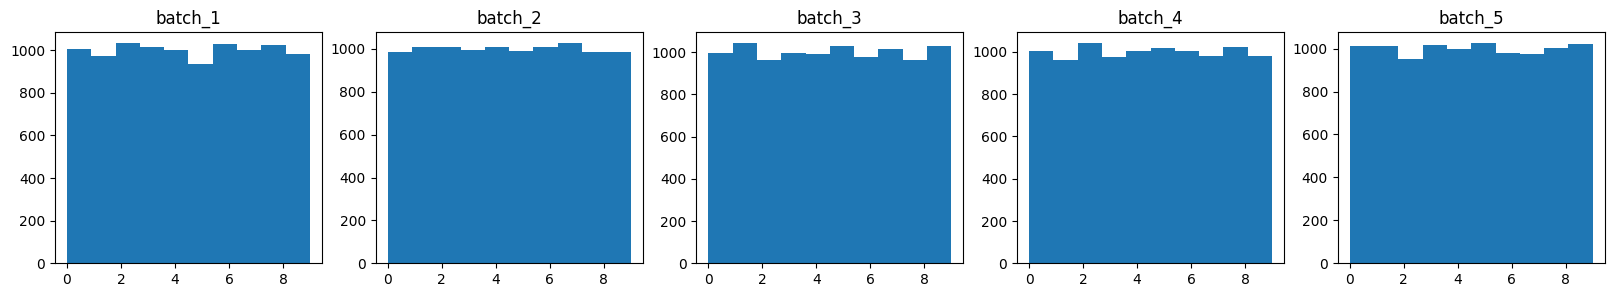

In [5]:
fig = plt.figure(figsize=(20, 3))
plt.subplot(1,5,1); plt.hist(batches["cifar10-batch-1"]["labels"]); plt.title("batch_1")
plt.subplot(1,5,2); plt.hist(batches["cifar10-batch-2"]["labels"]); plt.title("batch_2")
plt.subplot(1,5,3); plt.hist(batches["cifar10-batch-3"]["labels"]); plt.title("batch_3")
plt.subplot(1,5,4); plt.hist(batches["cifar10-batch-4"]["labels"]); plt.title("batch_4")
plt.subplot(1,5,5); plt.hist(batches["cifar10-batch-5"]["labels"]); plt.title("batch_5")

In [6]:

# define training, validation and test sets
def load_data():

    # make training set
    train_x = np.zeros((40000, 32, 32, 3)).astype("float32")
    train_x[0:10000] = batches['cifar10-batch-1']['data']
    train_x[10000:20000] = batches['cifar10-batch-2']['data']
    train_x[20000:30000] = batches['cifar10-batch-3']['data']
    train_x[30000:40000] = batches['cifar10-batch-4']['data']

    # ADD DATA TO THE VARIABLE x_train

    train_y = np.zeros((40000))
    train_y[0:10000] = batches['cifar10-batch-1']['labels']
    train_y[10000:20000] = batches['cifar10-batch-2']['labels']
    train_y[20000:30000] = batches['cifar10-batch-3']['labels']
    train_y[30000:40000] = batches['cifar10-batch-4']['labels']

    # make validation set
    val_x = batches['cifar10-batch-5']['data']
    val_y = batches['cifar10-batch-5']['labels']

    # make test set
    test_x = batches['cifar10-test']['data']

    # load labels CIFAR10
    label_to_names = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat',
                      4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}

    print ("-----------------------------------------------------")
    print (label_to_names)
    print ("-----------------------------------------------------")
    print ("> shape training set tensor: {}".format(train_x.shape))
    print ("> length training labels: {}".format(len(train_y)))
    print ("-----------------------------------------------------")
    print ("> shape validation set tensor: {}".format(val_x.shape))
    print ("> length training labels: {}".format(len(val_y)))
    print ("-----------------------------------------------------")
    print ("> shape test set tensor: {}".format(test_x.shape))

    return train_x, train_y, val_x, val_y, test_x

In [7]:
load_data()

-----------------------------------------------------
{0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}
-----------------------------------------------------
> shape training set tensor: (40000, 32, 32, 3)
> length training labels: 40000
-----------------------------------------------------
> shape validation set tensor: (10000, 32, 32, 3)
> length training labels: 10000
-----------------------------------------------------
> shape test set tensor: (10000, 32, 32, 3)


(array([[[[0.23137255, 0.24313726, 0.24705882],
          [0.16862746, 0.18039216, 0.1764706 ],
          [0.19607843, 0.1882353 , 0.16862746],
          ...,
          [0.61960787, 0.5176471 , 0.42352942],
          [0.59607846, 0.49019608, 0.4       ],
          [0.5803922 , 0.4862745 , 0.40392157]],
 
         [[0.0627451 , 0.07843138, 0.07843138],
          [0.        , 0.        , 0.        ],
          [0.07058824, 0.03137255, 0.        ],
          ...,
          [0.48235294, 0.34509805, 0.21568628],
          [0.46666667, 0.3254902 , 0.19607843],
          [0.47843137, 0.34117648, 0.22352941]],
 
         [[0.09803922, 0.09411765, 0.08235294],
          [0.0627451 , 0.02745098, 0.        ],
          [0.19215687, 0.10588235, 0.03137255],
          ...,
          [0.4627451 , 0.32941177, 0.19607843],
          [0.47058824, 0.32941177, 0.19607843],
          [0.42745098, 0.28627452, 0.16470589]],
 
         ...,
 
         [[0.8156863 , 0.6666667 , 0.3764706 ],
          [0.78823

##Task 1: Build a simple convolutional network

In [8]:
def build_neural_network(data_size_in, n_classes):

  inputs = layers.Input(shape=data_size_in)

  network_1 = layers.Conv2D(32, kernel_size=(5,5), activation="relu", padding="same")(inputs)
  network_2 = layers.MaxPool2D(pool_size=(2,2))(network_1)
  network_3 = layers.Conv2D(64, kernel_size=(5,5), activation="relu")(network_2)
  network_4 = layers.MaxPool2D(pool_size=(2,2))(network_3)
  network_5 = layers.Flatten()(network_4)

  network_6 = layers.Dense(128, activation="relu")(network_5)
  prediction = layers.Dense(n_classes, activation="softmax")(network_6)

  model = Model(inputs=inputs, outputs=prediction)
  print(model.summary())

  return model

###Loss Function & Optimization Algorithm

In [9]:
ls = "CategoricalCrossentropy"
lr = 0.1
sgd = keras.optimizers.SGD(learning_rate=lr)
metric = ["acc"]

network = build_neural_network(data_size_in, n_classes)
network.compile(loss=ls, optimizer=sgd, metrics=metric)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        2432      
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 2304)              0     

###One Hot Encoding

In [10]:
train_x, train_y, val_x, val_y, test_x = load_data()

train_y_one_hot = keras.utils.to_categorical(train_y, num_classes=n_classes, dtype="float32")
val_y_one_hot = keras.utils.to_categorical(val_y, num_classes=n_classes, dtype="float32")

print("train_y_one_hot.shape:", train_y_one_hot.shape)
print("val_y_one_hot.shape:", val_y_one_hot.shape)

print(np.sum(train_y_one_hot, axis=0))
print(np.sum(val_y_one_hot, axis=0))

-----------------------------------------------------
{0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}
-----------------------------------------------------
> shape training set tensor: (40000, 32, 32, 3)
> length training labels: 40000
-----------------------------------------------------
> shape validation set tensor: (10000, 32, 32, 3)
> length training labels: 10000
-----------------------------------------------------
> shape test set tensor: (10000, 32, 32, 3)
train_y_one_hot.shape: (40000, 10)
val_y_one_hot.shape: (10000, 10)
[3986. 3986. 4048. 3984. 4003. 3975. 4020. 4023. 3997. 3978.]
[1014. 1014.  952. 1016.  997. 1025.  980.  977. 1003. 1022.]


###Check Validation Performance Before Training

In [11]:
scores = network.evaluate(val_x, val_y_one_hot, batch_size=None)
val_loss = scores[0]
val_acc = scores[1]
print(("Initial Validation Accuracy = {:.2f}%".format(100*val_acc)))

313/313 [==============================] - 5s 15ms/step - loss: 2.3059 - acc: 0.1090
Initial Validation Accuracy = 10.90%


##Task 2: Train Your Network

In [12]:
def train_network(network, x_training, y_training, x_validation, y_validation, n_epoch, batch_size, network_filepath):
  tra_losses = []
  tra_accs = []
  val_losses = []
  val_accs = []

  best_validation_accuracy = 0

  for epoch in range(n_epoch):
    st = time.time()

    # train your network
    results = network.fit(x_training, y_training, batch_size=batch_size)

    # get training loss and accuracy
    training_loss = results.history["loss"]
    training_accuracy = results.history["acc"]

    # add to list
    tra_losses.append(training_loss)
    tra_accs.append(training_accuracy)

    # evaluate performance (loss and accuracy) on validation set
    scores = network.evaluate(x=x_validation, y=y_validation, batch_size=1)
    validation_loss = scores[0]
    validation_accuracy = scores[1]

    # add to list
    val_losses.append(validation_loss)
    val_accs.append(validation_accuracy)

    # (possibily) update best validation accuracy and save the network
    if validation_accuracy > best_validation_accuracy:
      best_validation_accuracy = validation_accuracy
      network.save(network_filepath)

    # visualization of the learning curves
    fig = plt.figure(figsize=(10, 5))
    tra_loss_plt, = plt.plot(range(len(tra_losses)), tra_losses, 'b')
    tra_accs_plt, = plt.plot(range(len(tra_accs)), tra_accs, 'c')
    val_loss_plt, = plt.plot(range(len(val_losses)), val_losses, 'm')
    val_acc_plt, = plt.plot(range(len(val_accs)), val_accs, 'r')
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend([tra_loss_plt, tra_accs_plt, val_loss_plt, val_acc_plt],
               ["training loss", "trainig accuracy", "validation loss", "validation accuracy"],
               loc="center left", bbox_to_anchor=(1, 0.5))
    plt.title("Best validation accuracy = {:.2f}%".format(100. * best_validation_accuracy))
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(0.2)

In [13]:
# define batch size
batch_size = 128
n_epoch = 10

file_dir = "./"
network_filepath = os.path.join(file_dir, "best_model_net_task_2.h5")

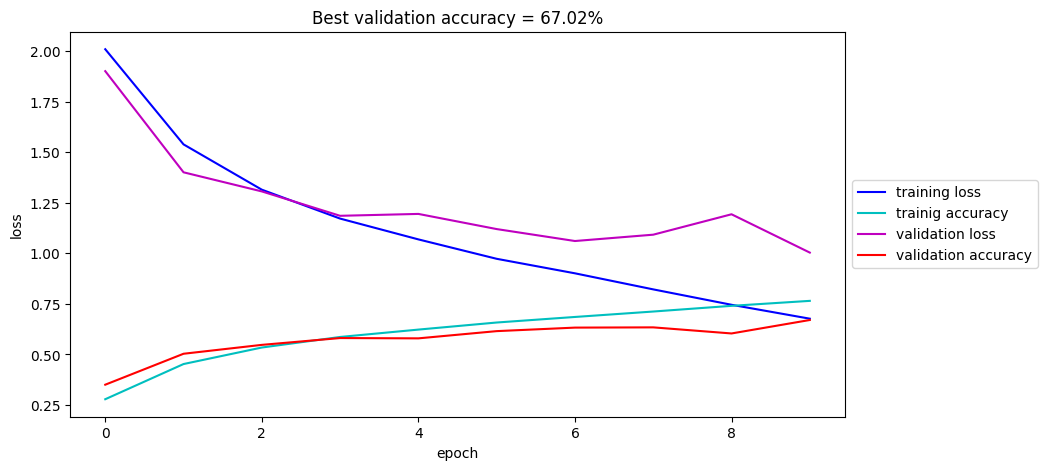

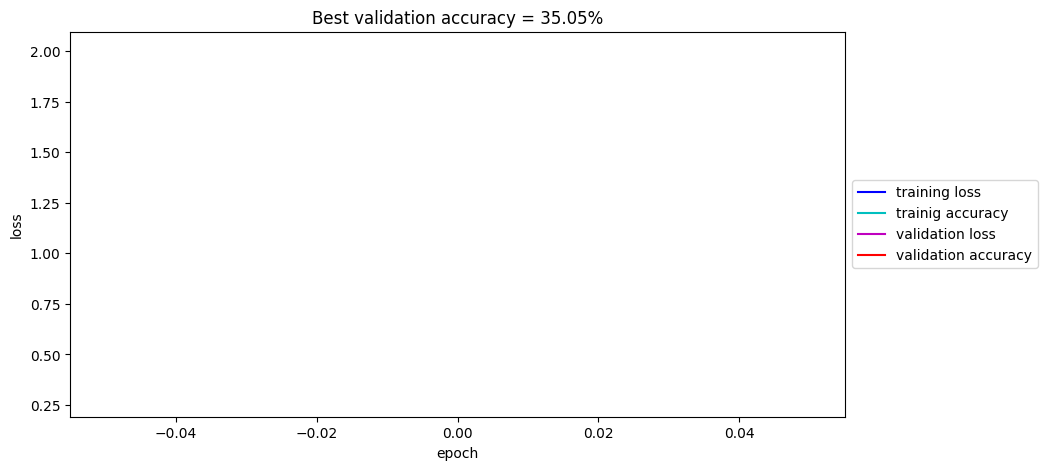

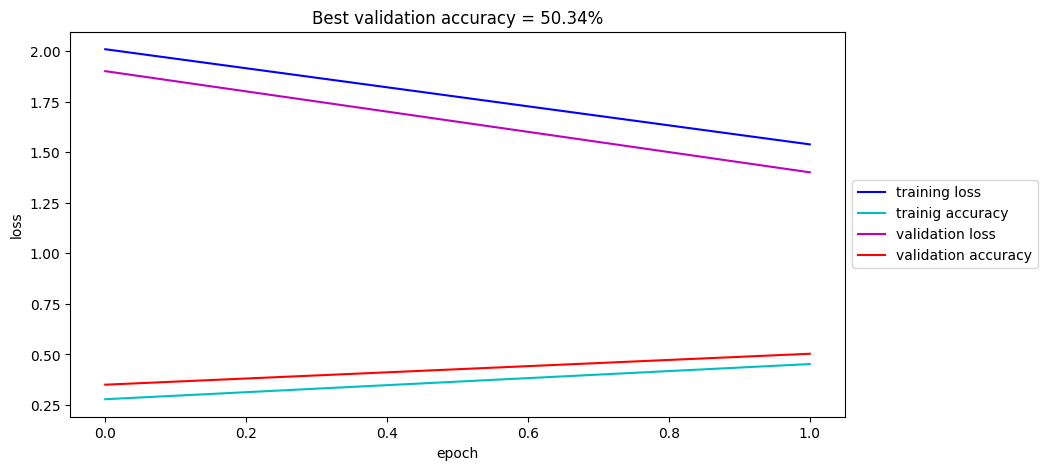

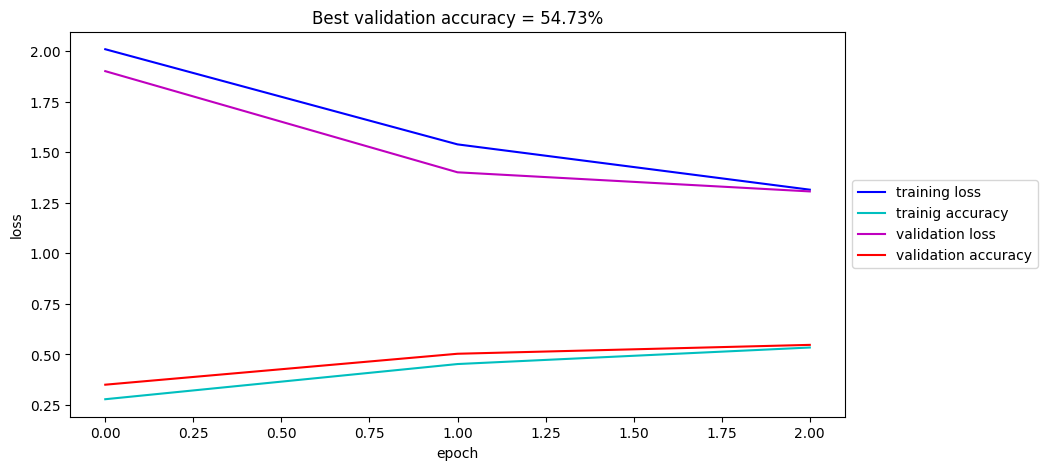

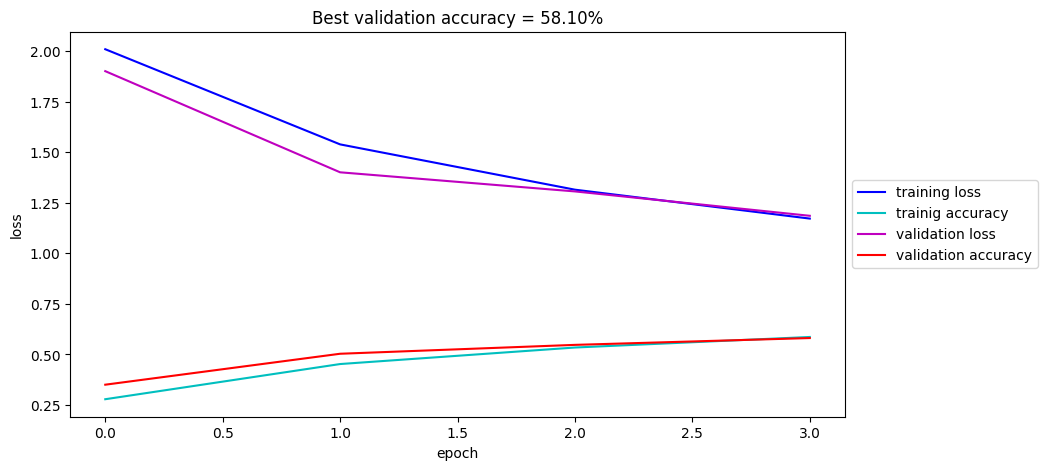

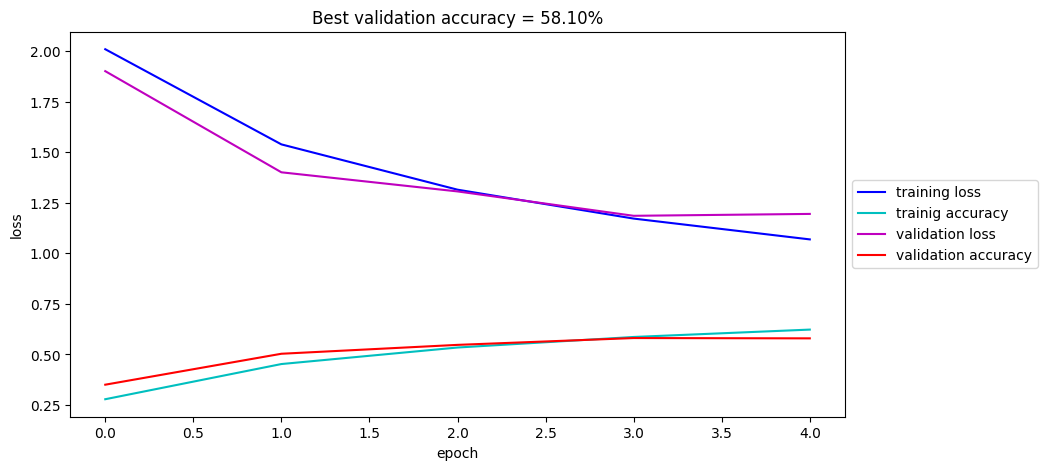

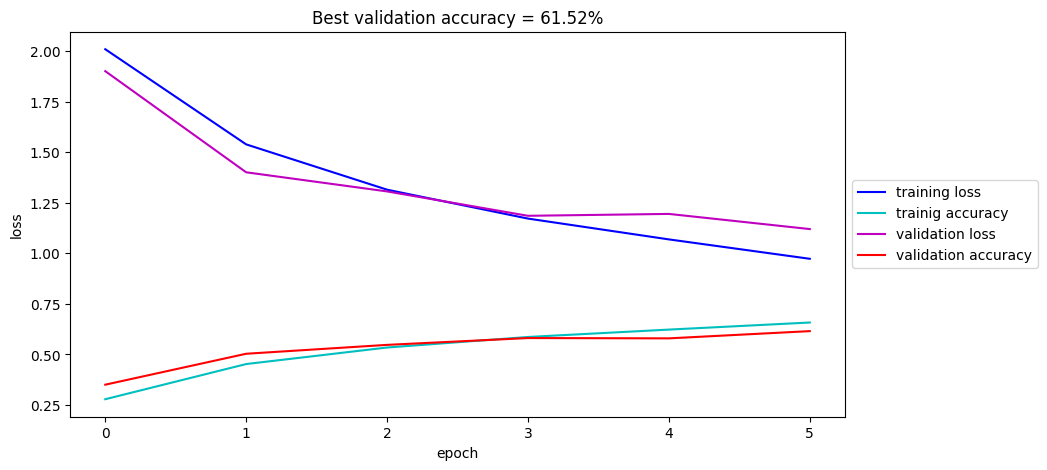

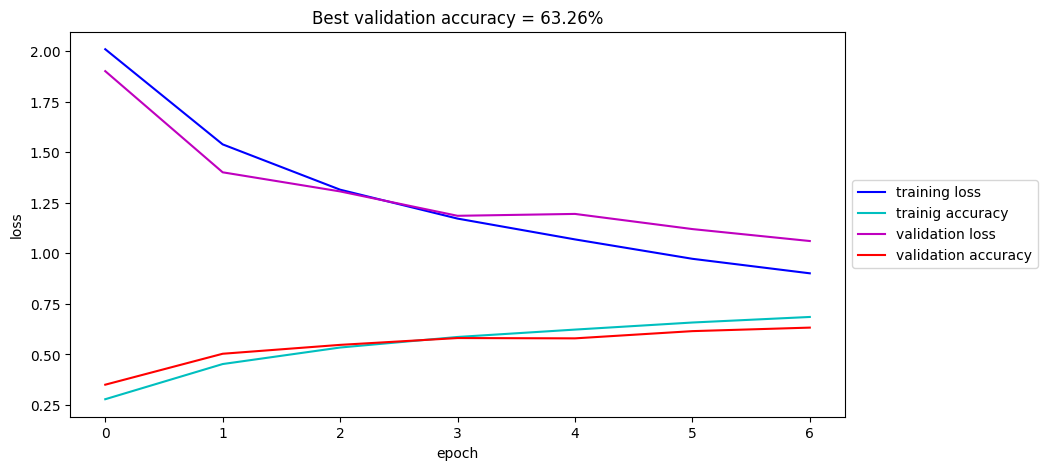

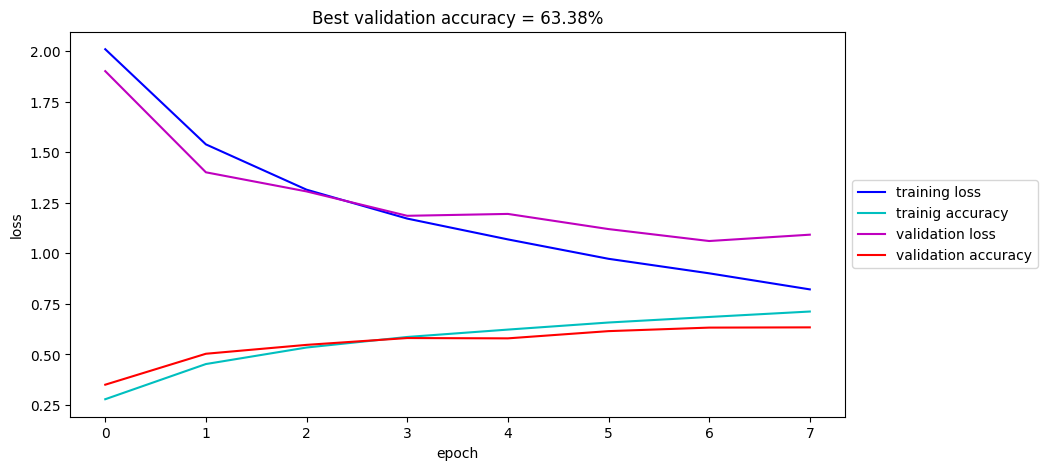

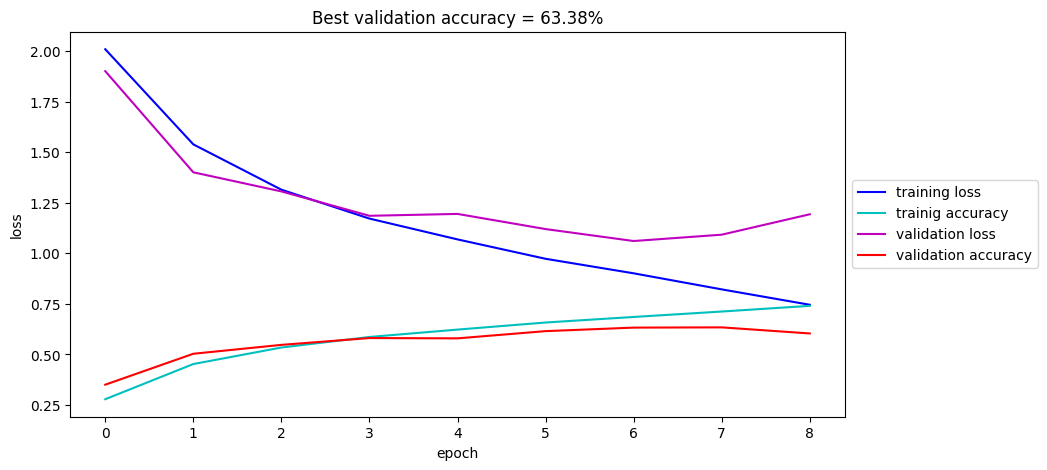

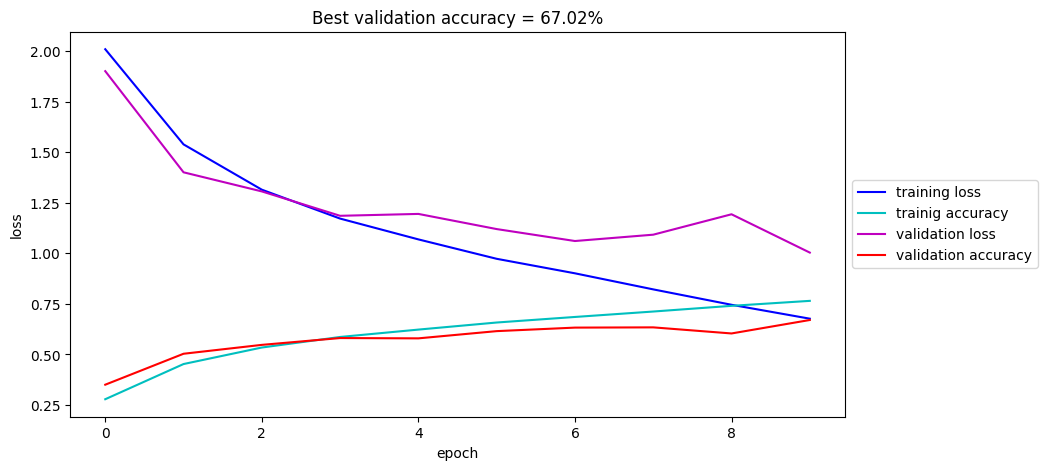

In [14]:
train_network(network, train_x, train_y_one_hot, val_x, val_y_one_hot, n_epoch, batch_size, network_filepath)

In [15]:
# Reload the model for best accuracy
best_network = keras.models.load_model(network_filepath)

network_name = "network_task_2"
test_prediction = best_network.predict(test_x, batch_size=128)
test_y = np.argmax(test_prediction, axis=1)

# write to csv file
ho = open(f"result_{network_name}.csv", "w")
ho.write("filename, label\n")
for filename, label in zip(batches["cifar10-test"]["filenames"], test_y):
  ho.write(f"{filename}, {label}\n")
ho.close()

79/79 [==============================] - 4s 55ms/step


##Task 3: Add Dropout Layers

In [16]:
def build_neural_network_drop(data_size_in, n_classes):
    inputs = layers.Input(shape=data_size_in)

    network_1 = layers.Conv2D(32, kernel_size=(5, 5), activation='relu')(inputs)
    network_2 = layers.MaxPool2D(pool_size=(2, 2))(network_1)
    network_3 = layers.Dropout(0.25)(network_2)

    network_4 = layers.Conv2D(64, kernel_size=(5, 5), activation='relu')(network_3)
    network_5 = layers.MaxPool2D(pool_size=(2, 2))(network_4)
    network_6 = layers.Dropout(0.25)(network_5)

    network_7 = layers.Flatten()(network_6)
    network_8 = layers.Dense(128, activation='relu')(network_7)
    network_9 = layers.Dropout(0.25)(network_8)

    prediction = layers.Dense(n_classes, activation='softmax')(network_9)

    model = Model(inputs=inputs, outputs=prediction)
    print(model.summary())

    return model


In [17]:
# compile network
network = build_neural_network_drop(data_size_in, n_classes)
network.compile(loss=ls, optimizer=keras.optimizers.legacy.SGD(learning_rate=lr), metrics=metric)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        2432      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 64)        51264     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                      

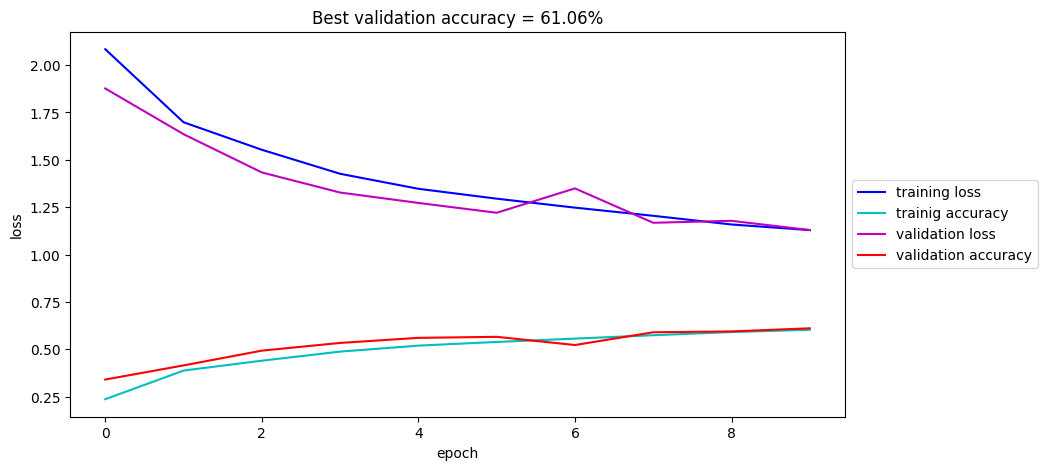

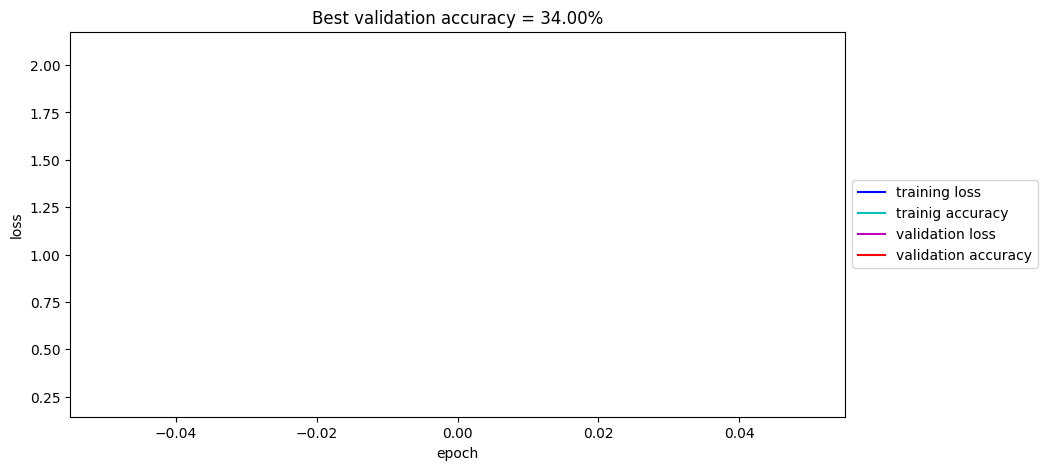

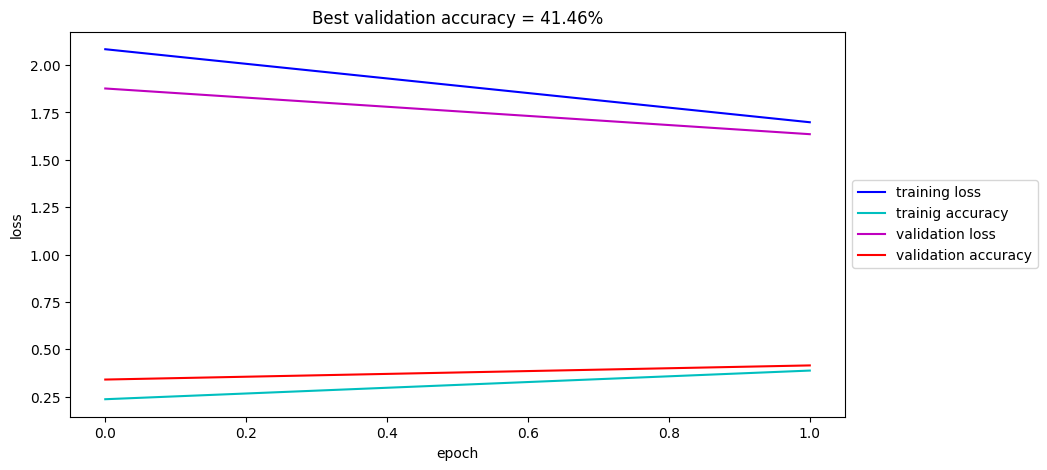

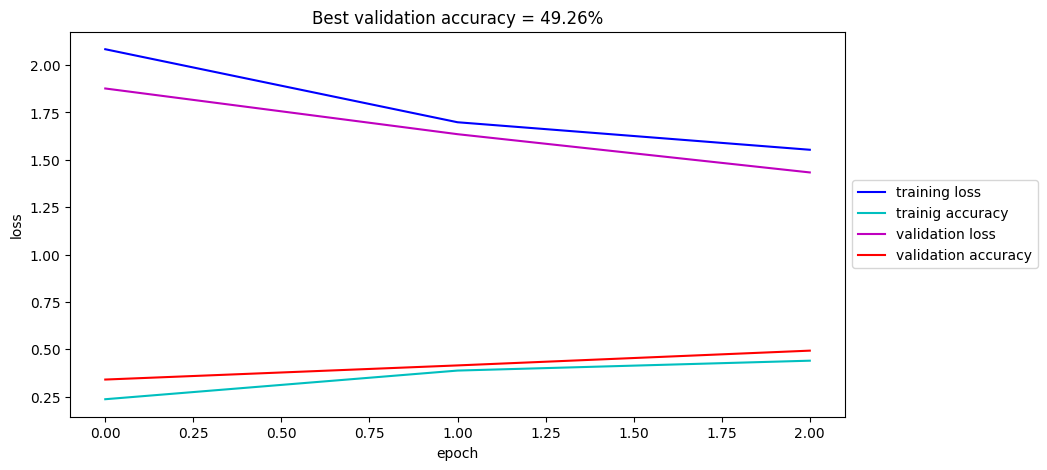

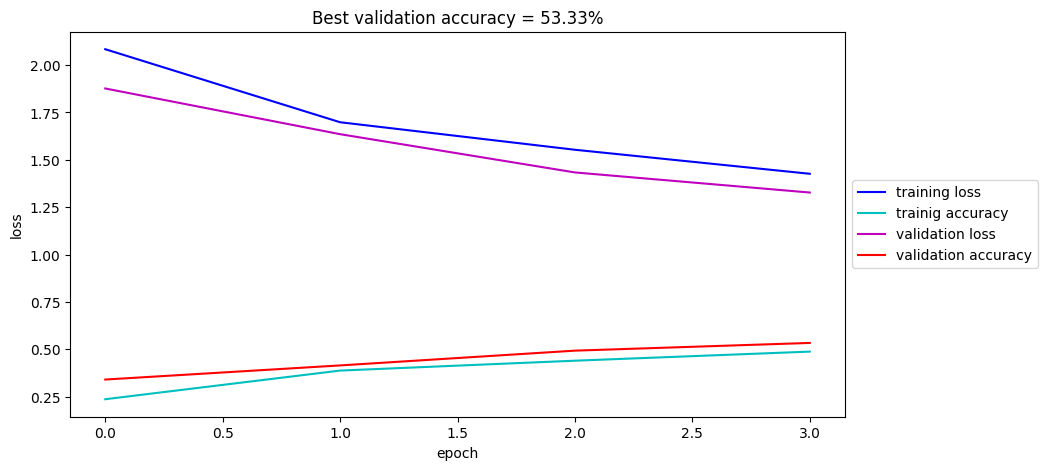

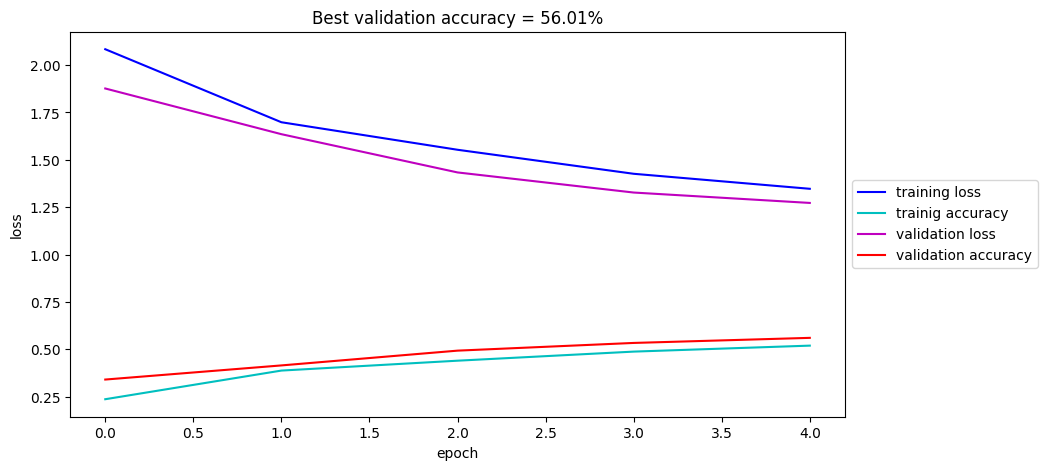

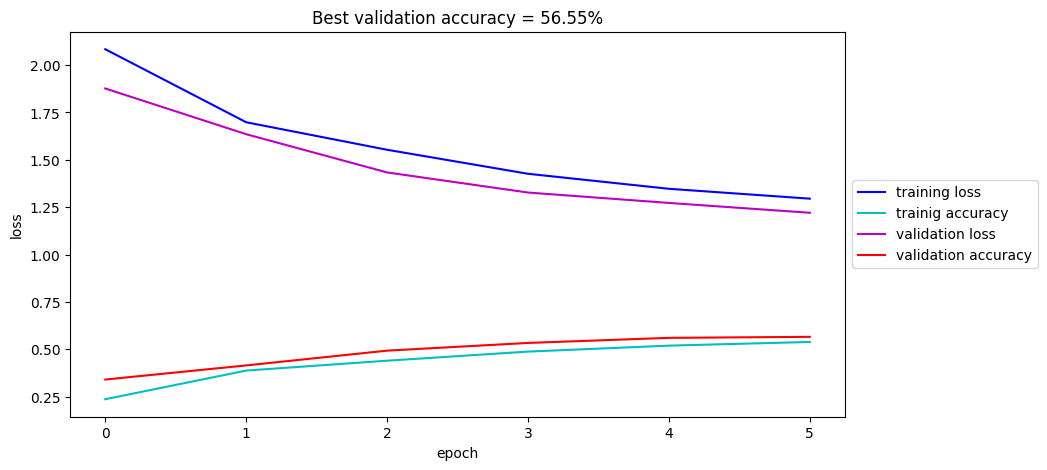

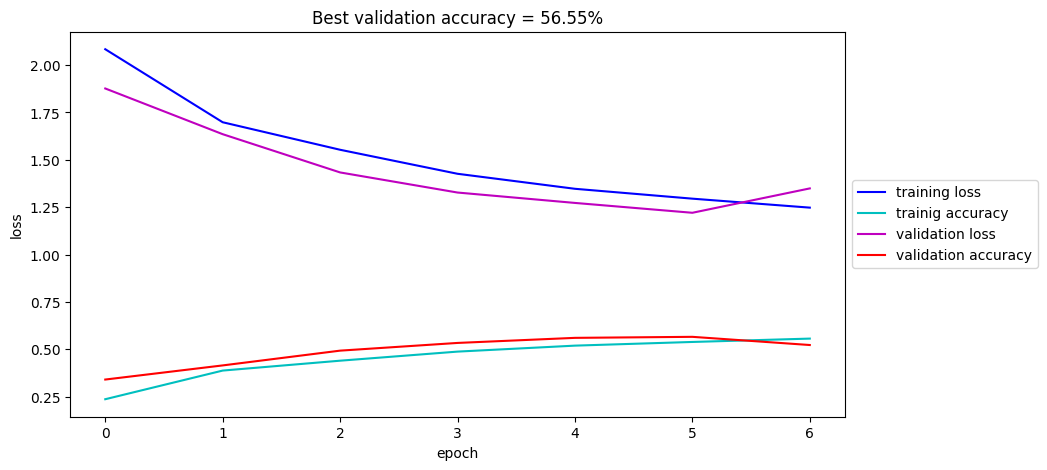

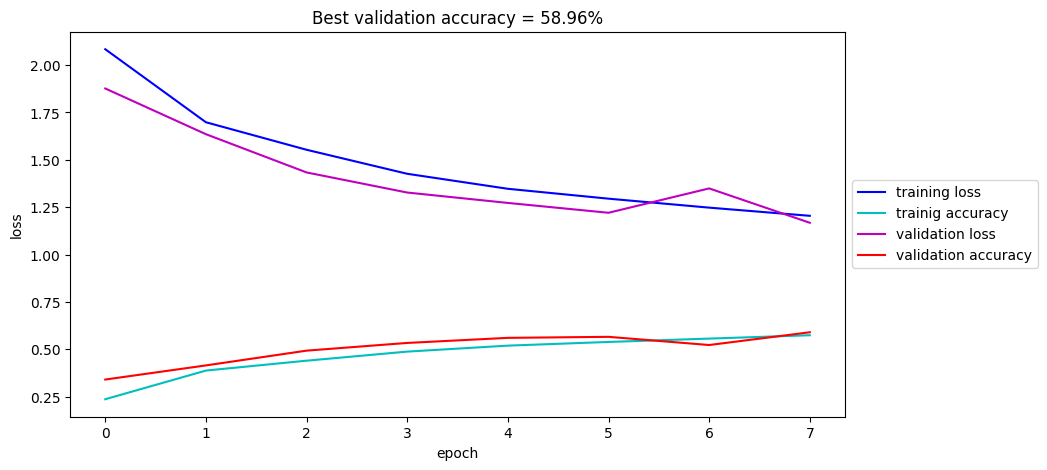

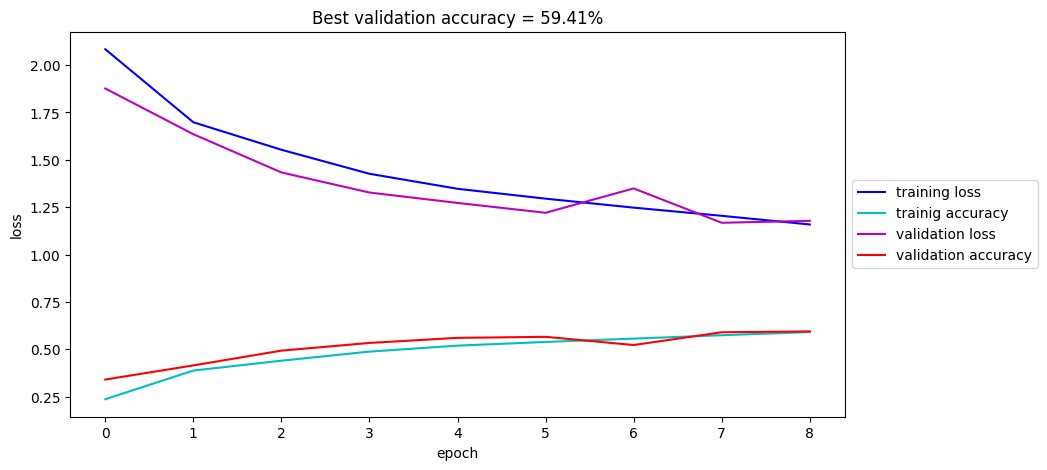

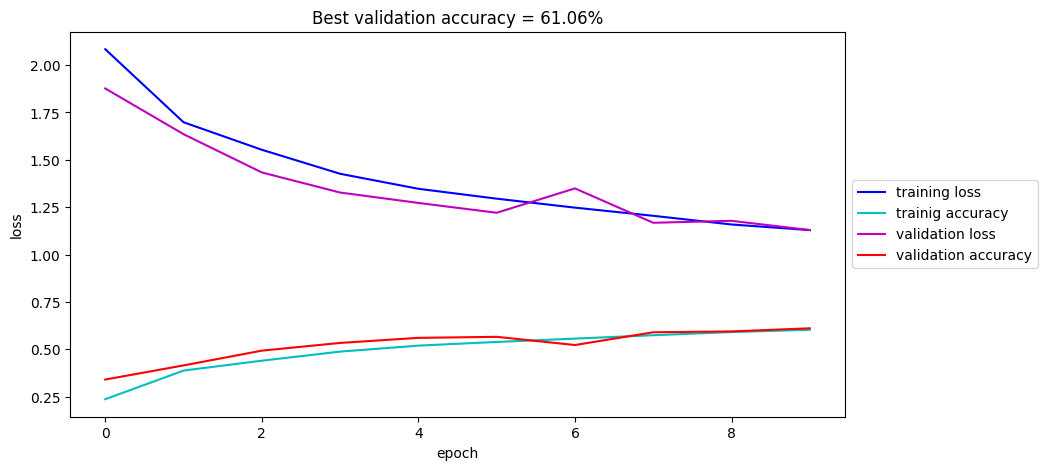

In [18]:
# train and validate network
network_filepath = os.path.join(file_dir, "best_model_net_dropout.h5")
train_network(network, train_x, train_y_one_hot, val_x, val_y_one_hot, n_epoch, batch_size, network_filepath)

In [19]:
# reload the model found for best accuracy
best_network = keras.models.load_model(network_filepath)

network_name = "networK_task_3"
test_prediction = best_network.predict(test_x, batch_size=128)
test_y = np.argmax(test_prediction, axis=1)

# write csv files with outputs
ho = open(f"./results_{network_name}.csv", "w")
ho.write("filename, label\n")
for filename, label in zip(batches["cifar10-test"]["filenames"], test_y):
  ho.write(f"{filename}, {label}\n")
ho.close()

79/79 [==============================] - 3s 39ms/step


##Task 4: Add batch Normalizatioon

In [20]:
def build_neural_network_batch_norm(data_size_in, n_classes):
  inputs = layers.Input(shape=data_size_in)

  network_1 = layers.Conv2D(32, kernel_size=(5,5), activation="relu")(inputs)
  network_2 = layers.BatchNormalization()(network_1)
  network_3 = layers.MaxPool2D(pool_size=(2,2))(network_2)
  network_4 = layers.Dropout(0.25)(network_3)

  network_5 = layers.Conv2D(64, kernel_size=(5,5), activation="relu")(network_4)
  network_6 = layers.BatchNormalization()(network_5)
  network_7 = layers.MaxPool2D(pool_size=(2,2))(network_6)
  network_8 = layers.Dropout(0.25)(network_7)

  network_9 = layers.Flatten()(network_8)
  network_10 = layers.Dropout(0.25)(network_9)
  network_11 = layers.Dense(128, activation="relu")(network_10)
  network_12 = layers.BatchNormalization()(network_11)
  network_13 = layers.Dropout(0.25)(network_12)
  prediction = layers.Dense(n_classes, activation="softmax")(network_13)

  model = Model(inputs=inputs, outputs=prediction)
  print(model.summary())

  return model

In [21]:
# compile the network
network = build_neural_network_batch_norm(data_size_in, n_classes)
network.compile(loss=ls, optimizer=keras.optimizers.legacy.SGD(learning_rate=lr), metrics=metric)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 32)        2432      
                                                                 
 batch_normalization (Batch  (None, 28, 28, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 14, 14, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 10, 10, 64)        5126

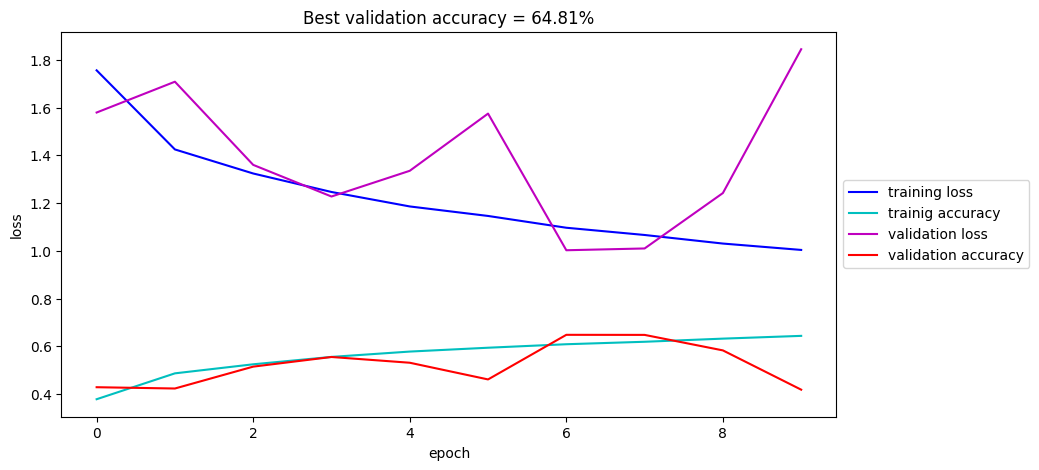

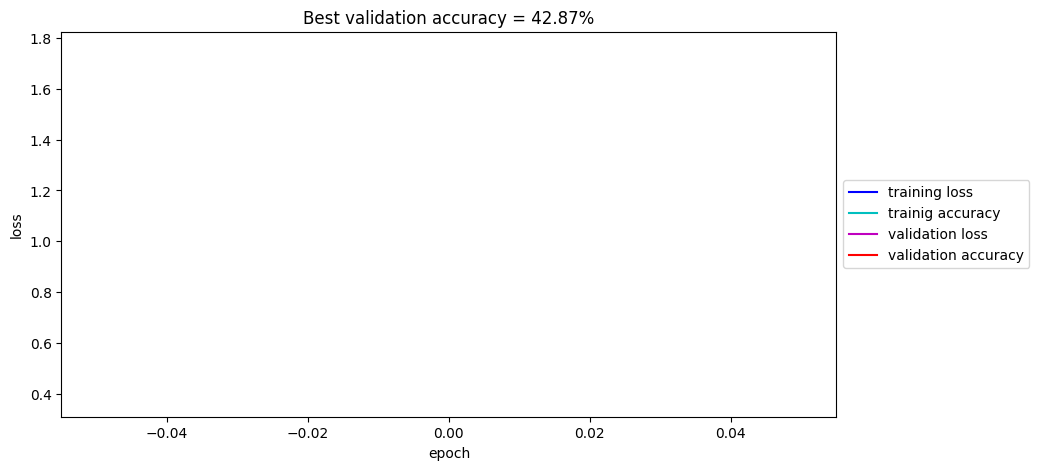

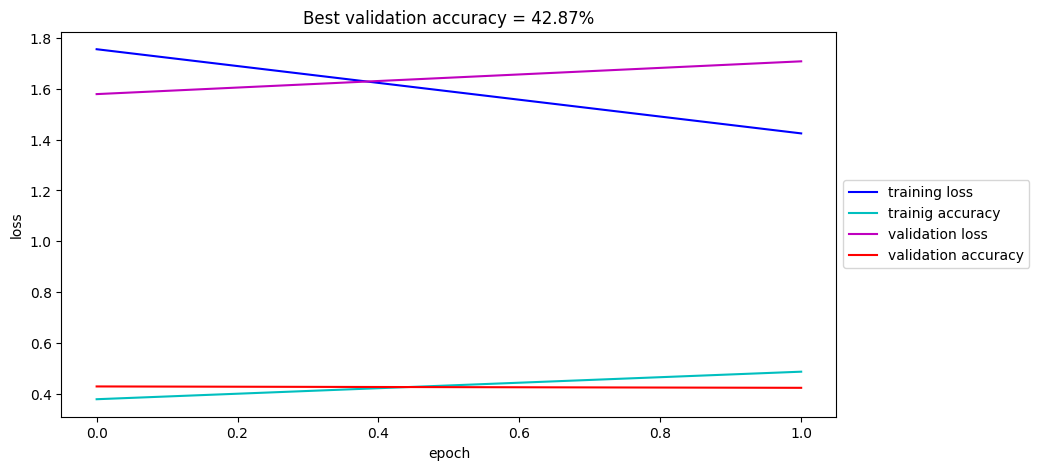

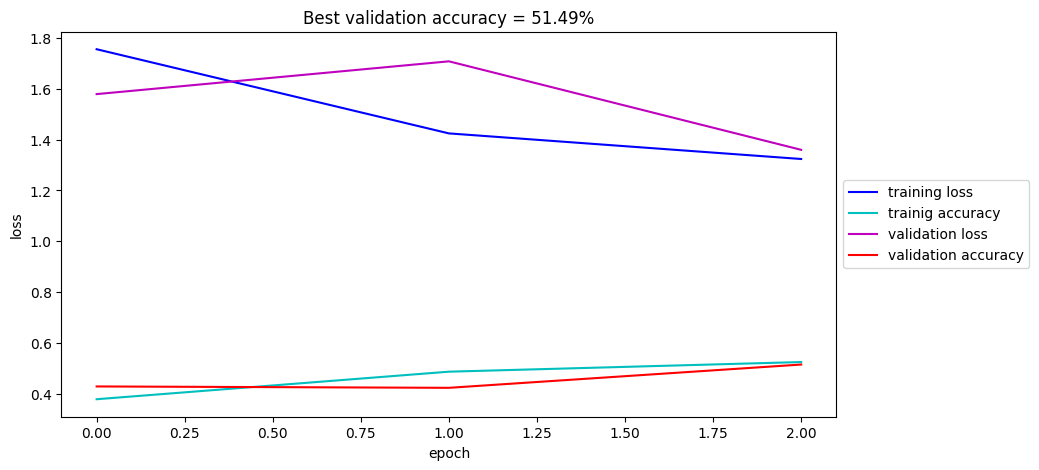

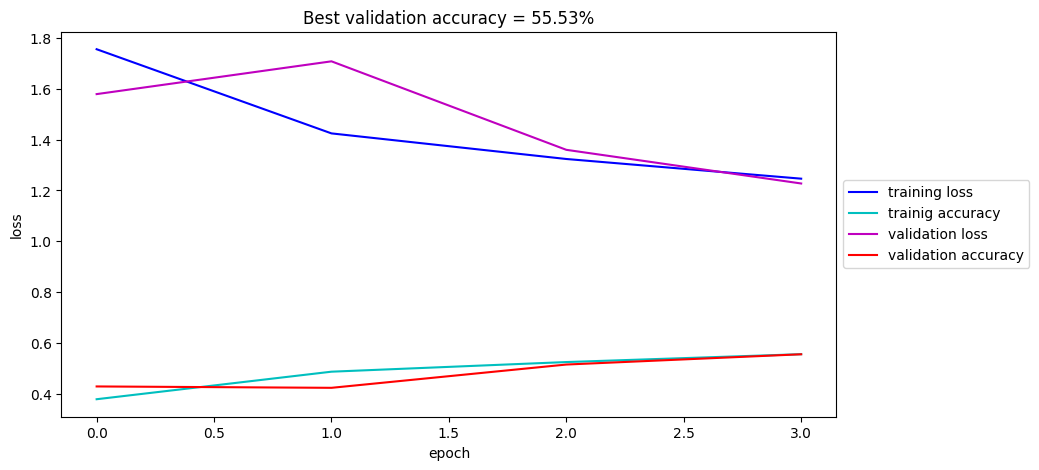

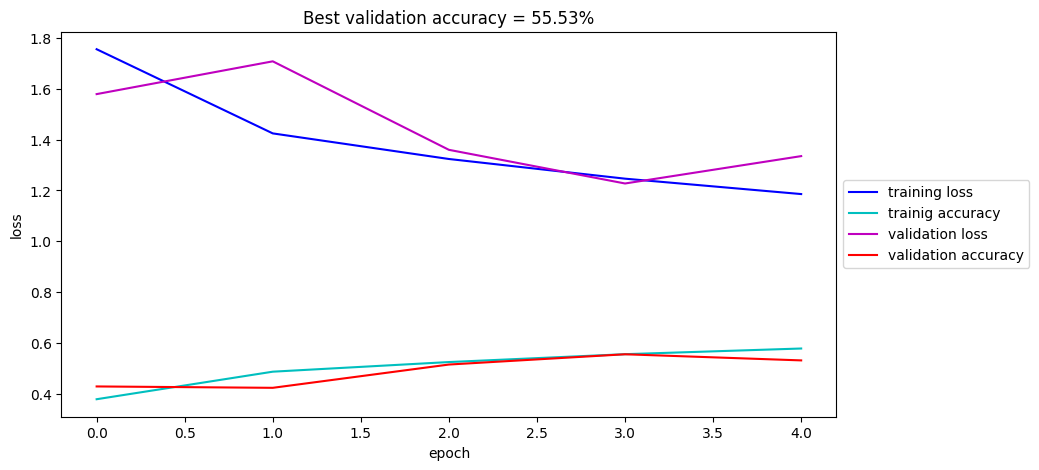

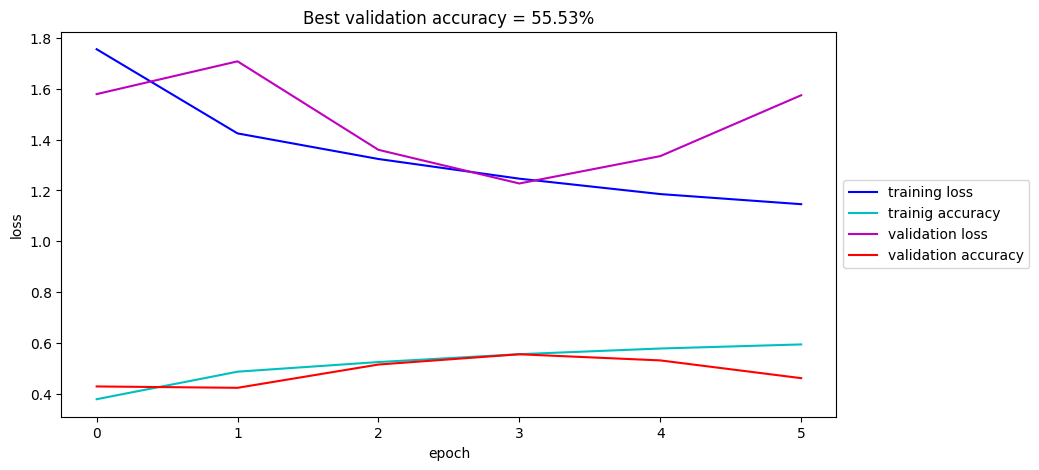

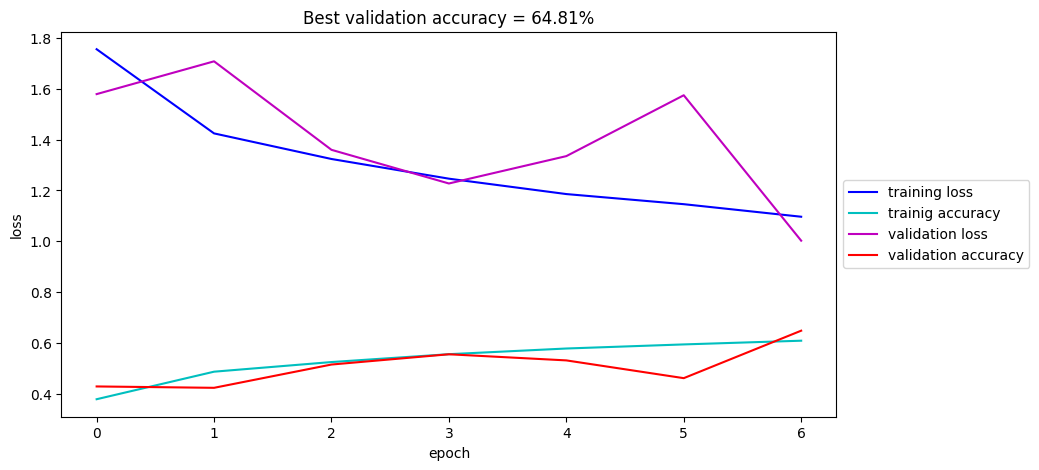

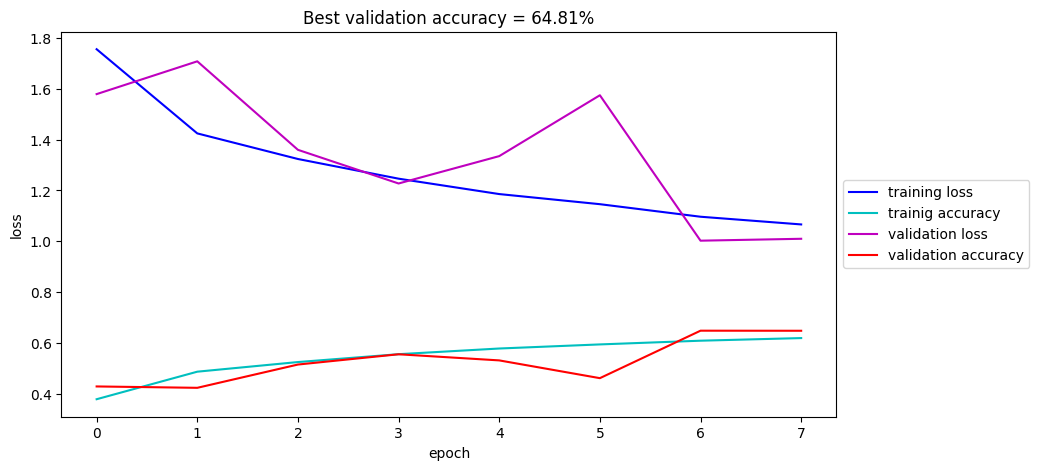

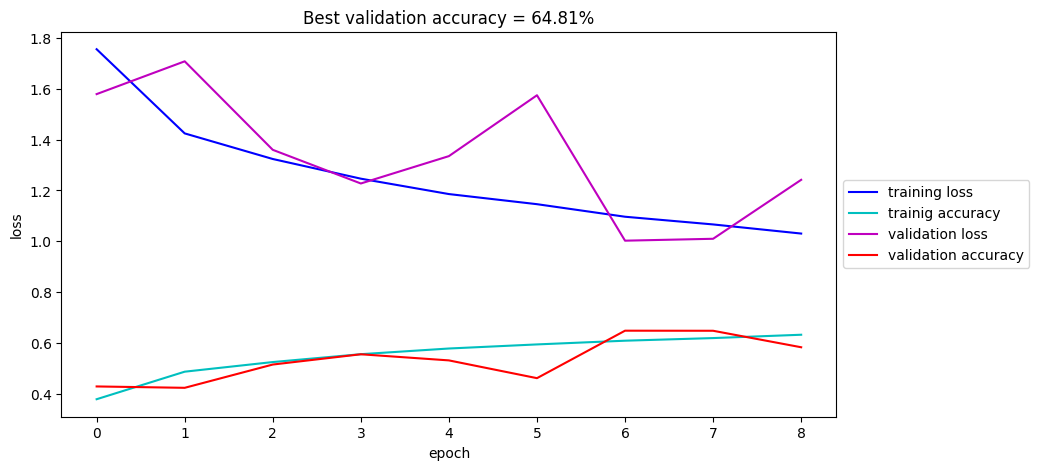

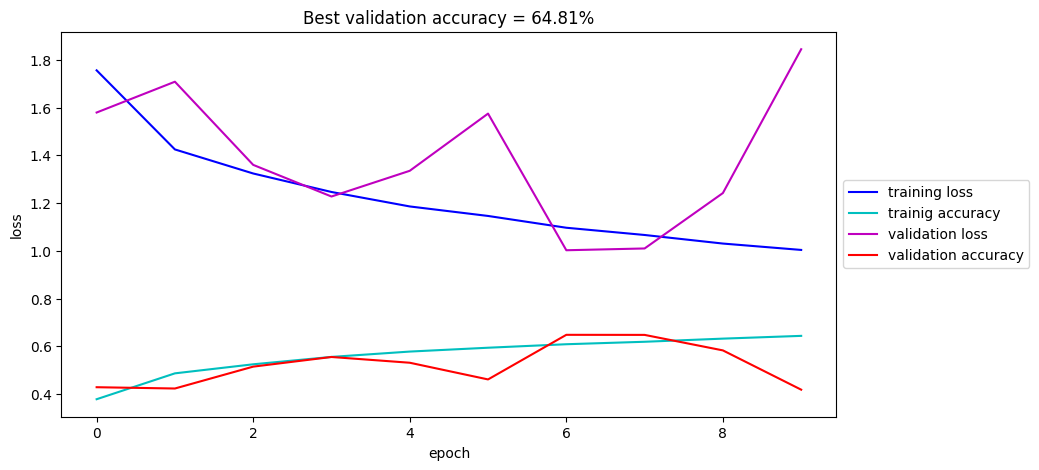

In [22]:
# train and validate network
network_filepath = os.path.join(file_dir, "best_model_net_batchnorm.h5")
train_network(network, train_x, train_y_one_hot, val_x, val_y_one_hot, n_epoch, batch_size, network_filepath)

In [23]:
# Reload the model for best accuracy
best_network = keras.models.load_model(network_filepath)
network_name = "network_task_4"
task_prediction = best_network.predict(test_x, batch_size=128)
test_y = np.argmax(test_prediction, axis=1)
# write to csv
ho = open(f"results_{network_name}", "w")
ho.write("filename, label\n")
for filename, label in zip(batches["cifar10-test"]["filenames"], test_y):
  ho.write(f"{filename}, {label}\n")
ho.close()

79/79 [==============================] - 3s 37ms/step


##Task 5: Try different initialization strategies

In [24]:
def build_neural_network_diff_init(data_size_in, n_classes):
  initializer = tf.keras.initializers.HeNormal()
  bias_init = tf.keras.initializers.zeros()

  inputs = layers.Input(shape=data_size_in)

  network_1 = layers.Conv2D(64, kernel_size=(5,5), activation="relu", padding="same",
                            kernel_initializer=initializer, bias_initializer=bias_init)(inputs)
  network_2 = layers.BatchNormalization()(network_1)
  network_3 = layers.Conv2D(64, kernel_size=(5,5), activation="relu")(network_2)
  network_4 = layers.BatchNormalization()(network_3)
  network_5 = layers.MaxPool2D(pool_size=(2,2))(network_4)
  network_6 = layers.Dropout(0.25)(network_5)

  network_7 = layers.Conv2D(32, kernel_size=(5,5), activation="relu")(network_6)
  network_8 = layers.BatchNormalization()(network_7)
  network_9 = layers.MaxPool2D(pool_size=(2,2))(network_8)
  network_10 = layers.Dropout(0.25)(network_9)

  network_11 = layers.Flatten()(network_10)
  network_12 = layers.Dense(256, activation="relu", kernel_initializer=initializer)(network_11)
  network_13 = layers.BatchNormalization()(network_12)
  network_14 = layers.Dropout(0.25)(network_13)
  network_15 = layers.Dense(128, activation="relu", kernel_initializer=initializer)(network_14)
  network_16 = layers.BatchNormalization()(network_15)
  network_17 = layers.Dropout(0.25)(network_16)

  prediction = layers.Dense(n_classes, activation="softmax")(network_17)

  model = Model(inputs=inputs, outputs=prediction)
  print(model.summary())

  return model

In [25]:
# compile the network
network = build_neural_network_diff_init(data_size_in, n_classes)
network.compile(loss=ls, optimizer=keras.optimizers.legacy.SGD(learning_rate=lr), metrics=metric)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 64)        4864      
                                                                 
 batch_normalization_3 (Bat  (None, 32, 32, 64)        256       
 chNormalization)                                                
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 64)        102464    
                                                                 
 batch_normalization_4 (Bat  (None, 28, 28, 64)        256       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 14, 14, 64)        0   

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer HeNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


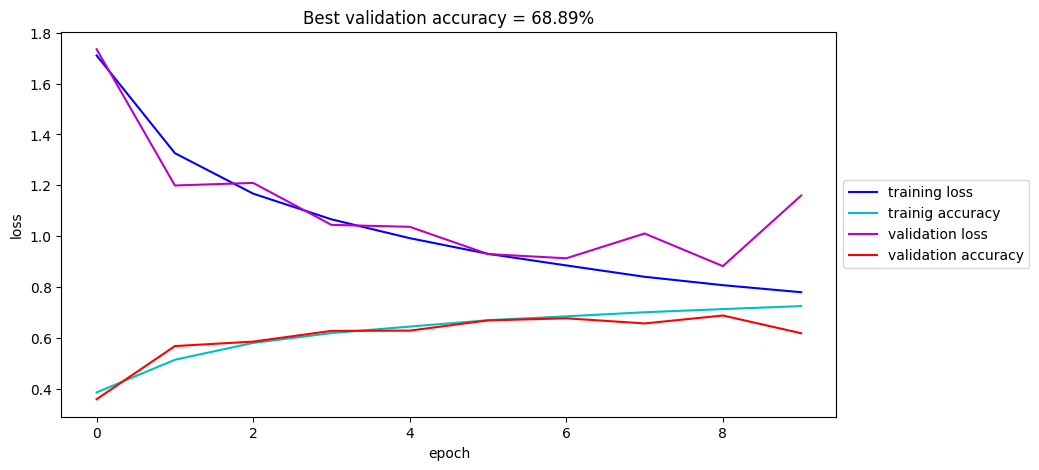

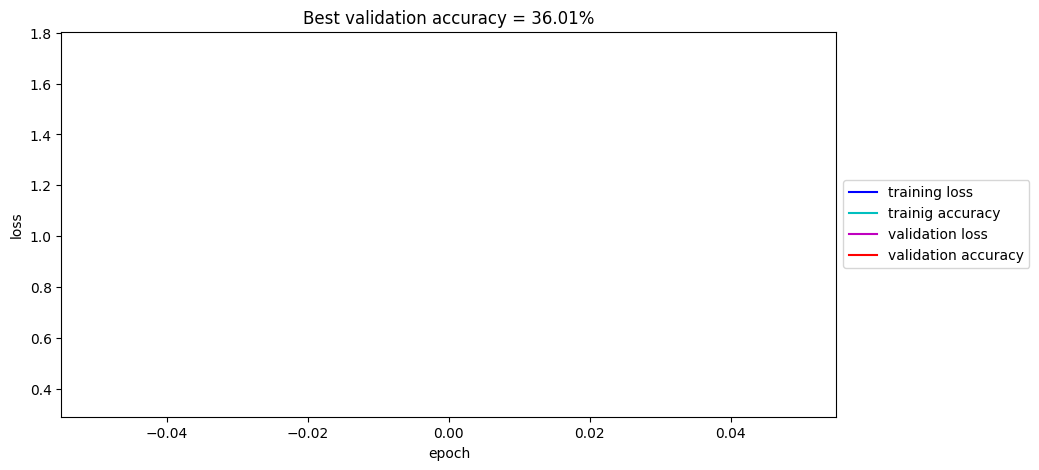

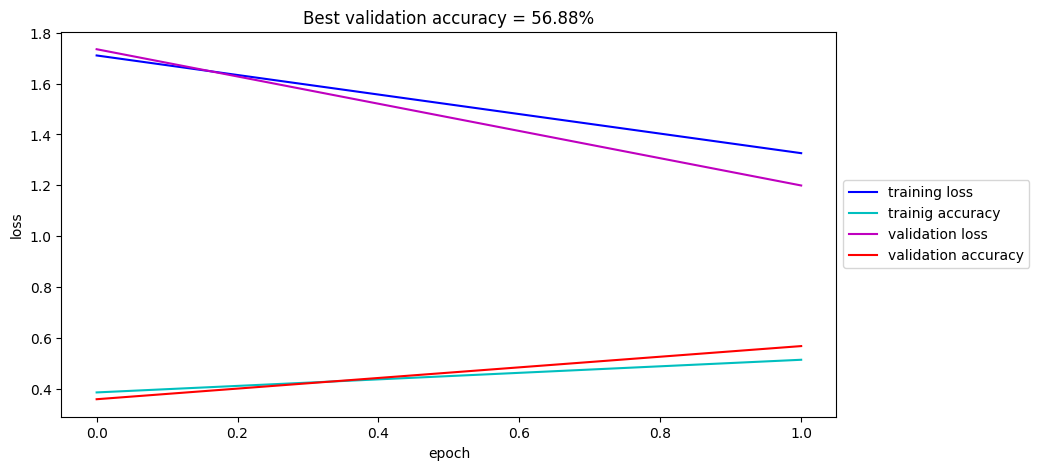

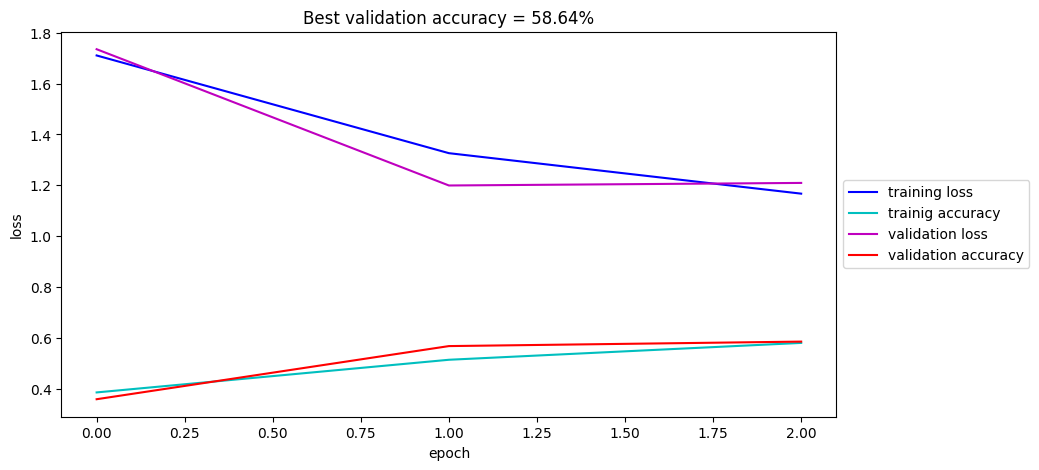

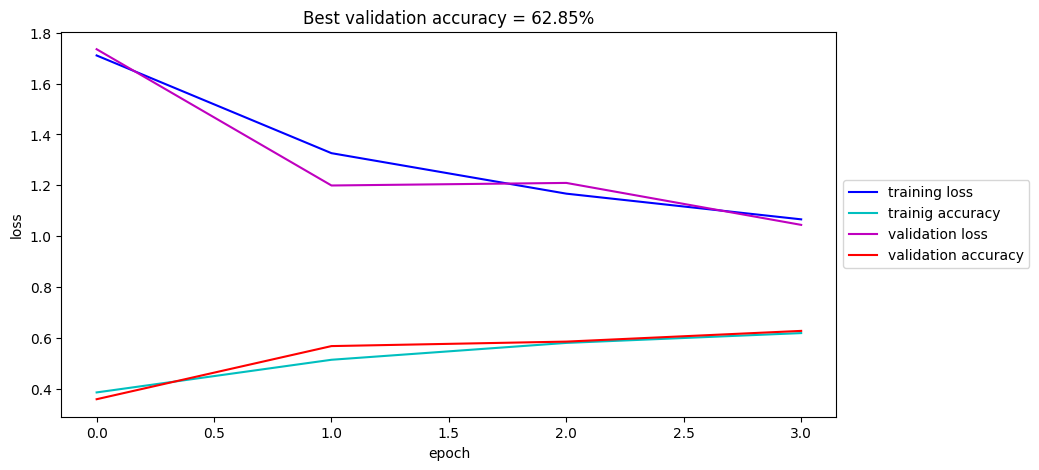

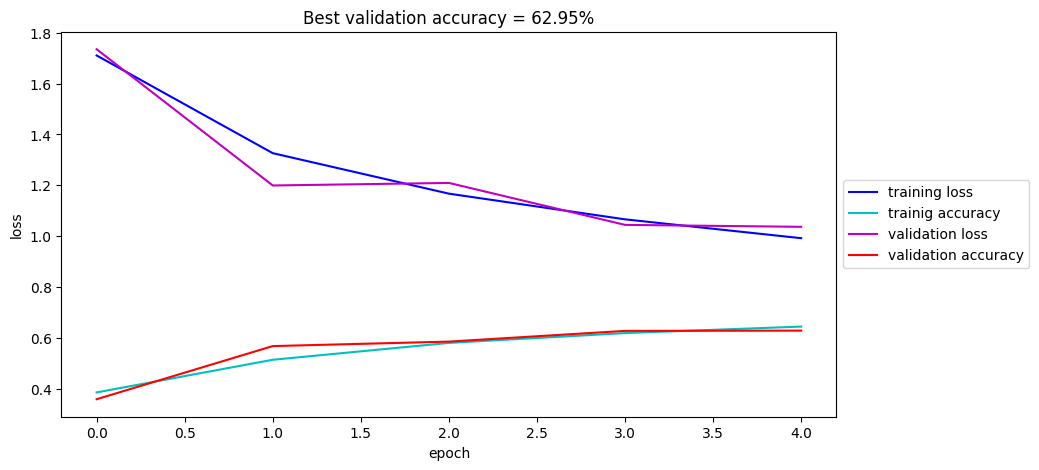

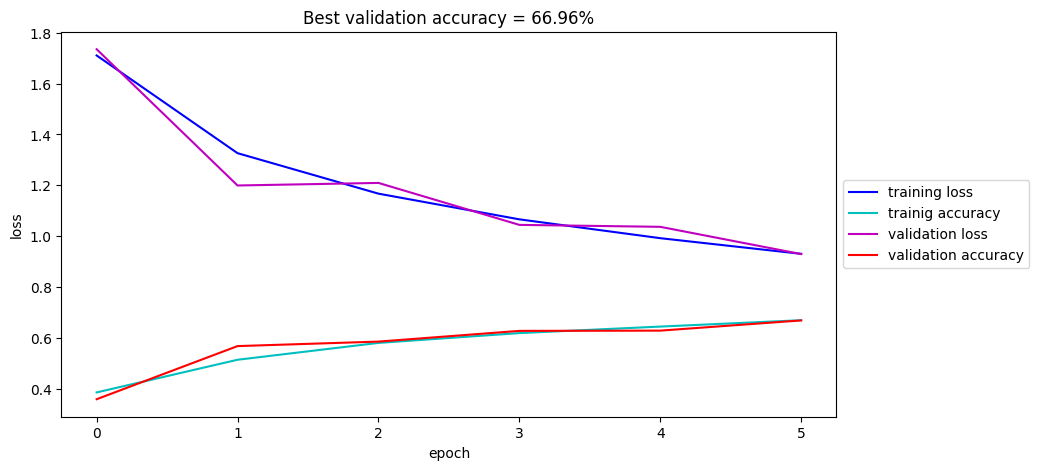

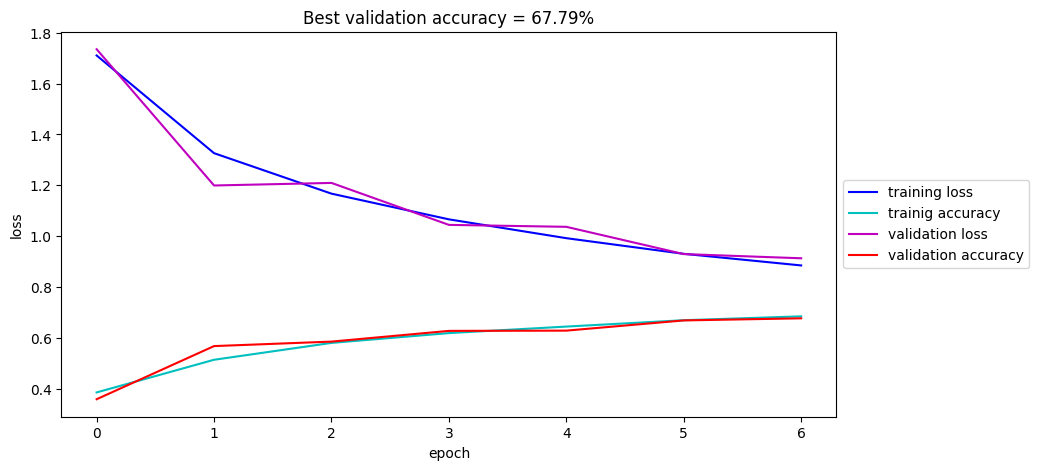

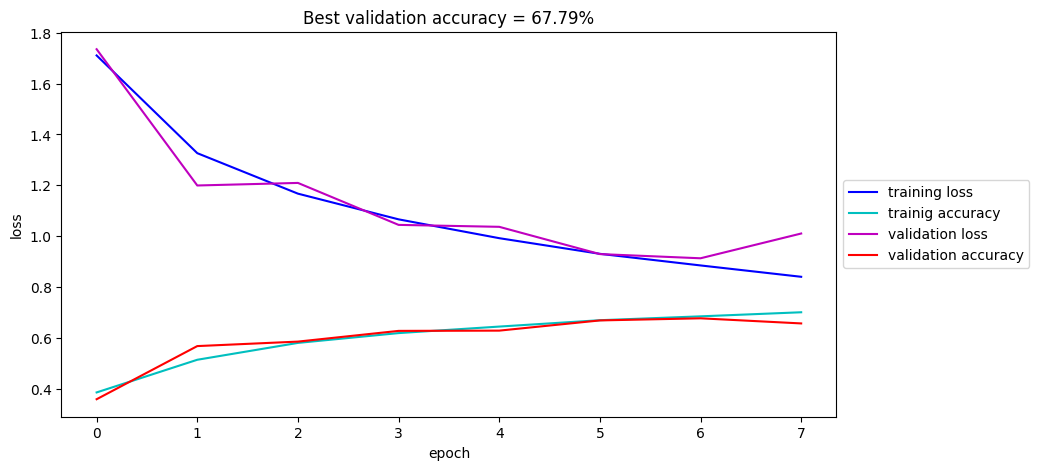

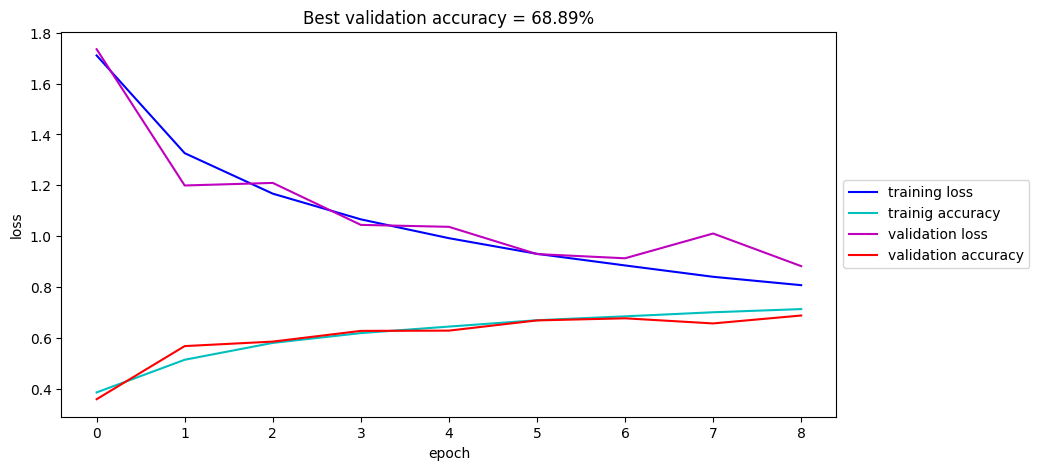

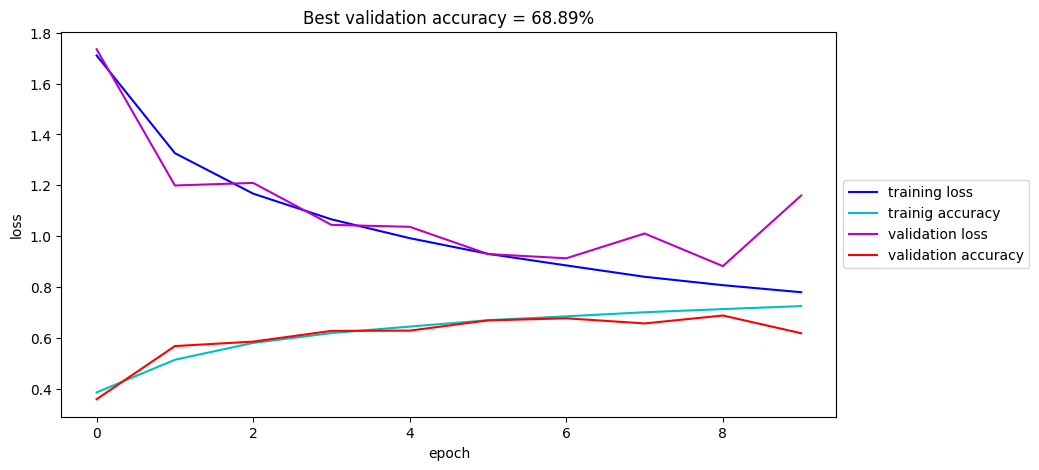

In [26]:
# train and validate network
network_filepath = os.path.join(file_dir, "best_model_net_init.h5")
train_network(network, train_x, train_y_one_hot, val_x, val_y_one_hot, n_epoch, batch_size, network_filepath)

In [27]:
# reload the model for best accuracy
best_network = keras.models.load_model(network_filepath)

network_name = "network_task_5"
test_prediction = best_network.predict(test_x, batch_size=128)
test_y = np.argmax(test_prediction, axis=1)

# write to csv
ho = open(f"results_{network_name}", "w")
ho.write("filename, label\n")
for filename, label in zip(batches["cifar10-test"]["filenames"], test_y):
  ho.write(f"{filename}, {label}")
ho.close()

79/79 [==============================] - 26s 325ms/step


##Task 6: Try different nonlinearities

In [28]:
def build_neural_network_diff_nonlin(data_size_in, n_classes):
  initializer = tf.keras.initializers.HeNormal()
  bias_init = tf.keras.initializers.zeros()

  inputs = layers.Input(shape=data_size_in)

  network_1 = layers.Conv2D(64, kernel_size=(5,5), activation="gelu", padding="same",
                            kernel_initializer=initializer, bias_initializer=bias_init)(inputs)
  network_2 = layers.BatchNormalization()(network_1)
  network_3 = layers.Conv2D(64, kernel_size=(5,5), activation="gelu")(network_2)
  network_4 = layers.BatchNormalization()(network_3)
  network_5 = layers.MaxPool2D(pool_size=(2,2))(network_4)
  network_6 = layers.Dropout(0.25)(network_5)

  network_7 = layers.Conv2D(32, kernel_size=(5,5), activation="gelu")(network_6)
  network_8 = layers.BatchNormalization()(network_7)
  network_9 = layers.MaxPool2D(pool_size=(2,2))(network_8)
  network_10 = layers.Dropout(0.25)(network_9)

  network_11 = layers.Flatten()(network_10)
  network_12 = layers.Dense(256, activation="gelu", kernel_initializer=initializer)(network_11)
  network_13 = layers.BatchNormalization()(network_12)
  network_14 = layers.Dropout(0.25)(network_13)
  network_15 = layers.Dense(128, activation="gelu", kernel_initializer=initializer)(network_14)
  network_16 = layers.BatchNormalization()(network_15)
  network_17 = layers.Dropout(0.25)(network_16)

  prediction = layers.Dense(n_classes, activation="softmax")(network_17)

  model = Model(inputs=inputs, outputs=prediction)
  print(model.summary())

  return model

In [29]:
# compile the network
network = build_neural_network_diff_nonlin(data_size_in, n_classes)
network.compile(loss=ls, optimizer=keras.optimizers.legacy.SGD(learning_rate=lr), metrics=metric)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 64)        4864      
                                                                 
 batch_normalization_8 (Bat  (None, 32, 32, 64)        256       
 chNormalization)                                                
                                                                 
 conv2d_10 (Conv2D)          (None, 28, 28, 64)        102464    
                                                                 
 batch_normalization_9 (Bat  (None, 28, 28, 64)        256       
 chNormalization)                                                
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 14, 14, 64)        0   

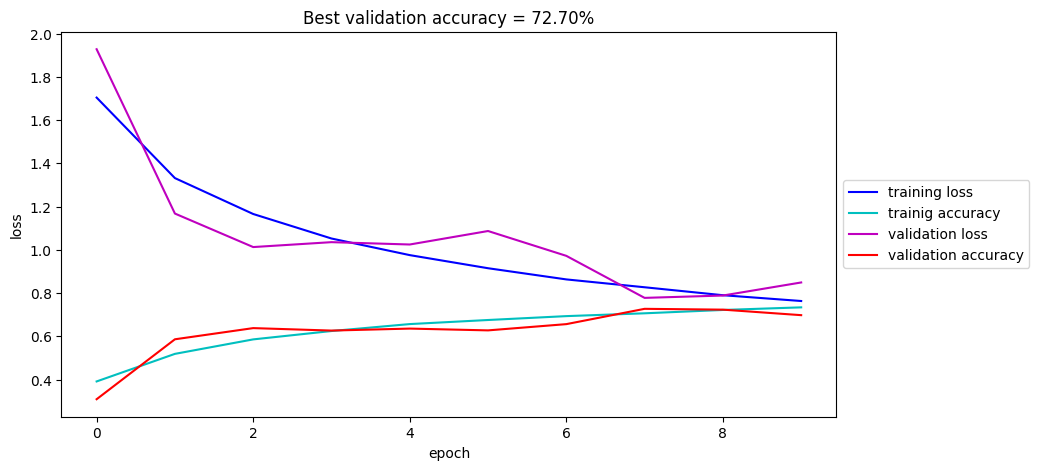

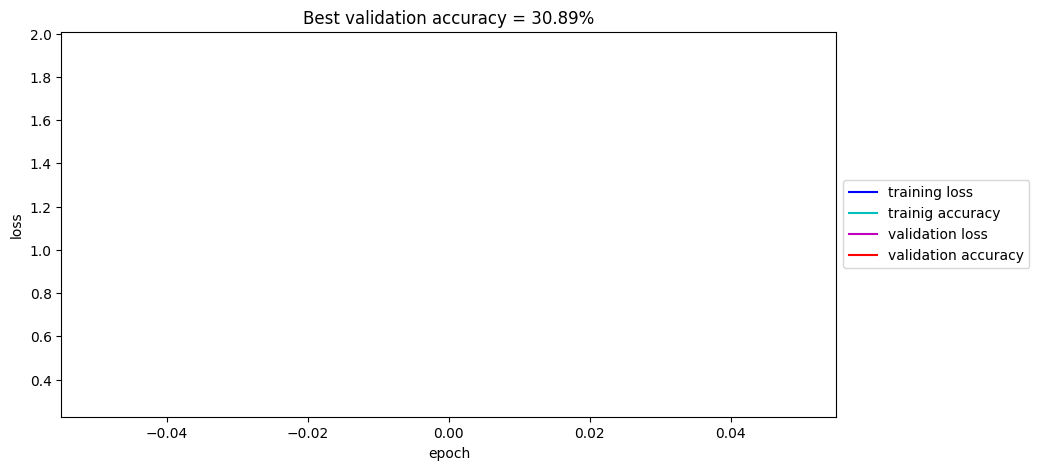

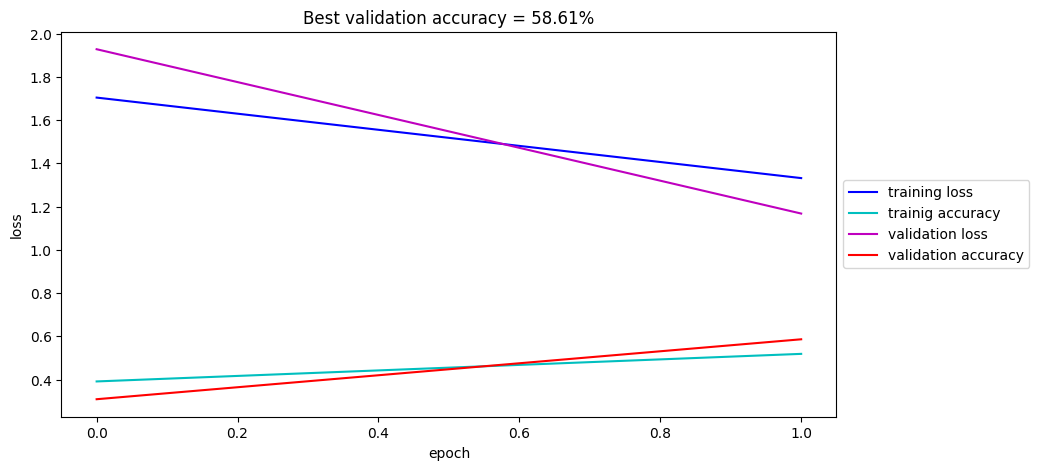

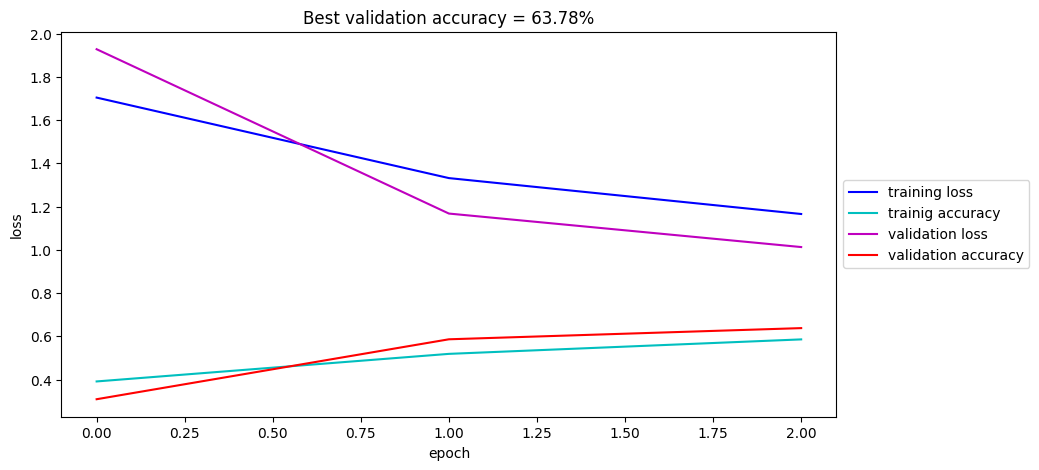

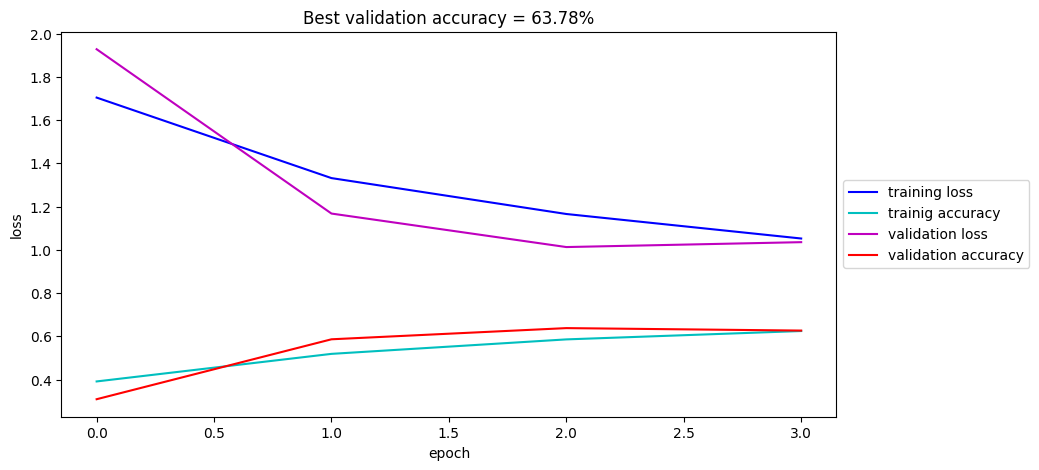

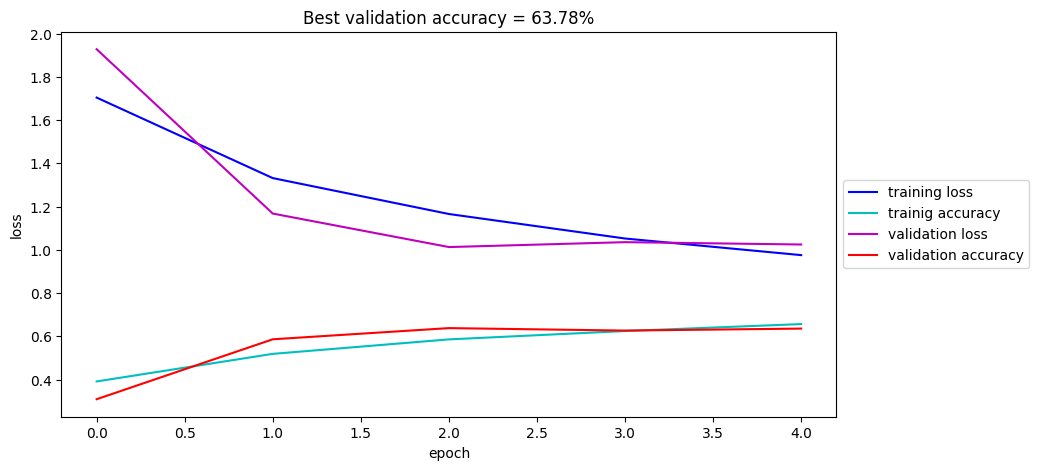

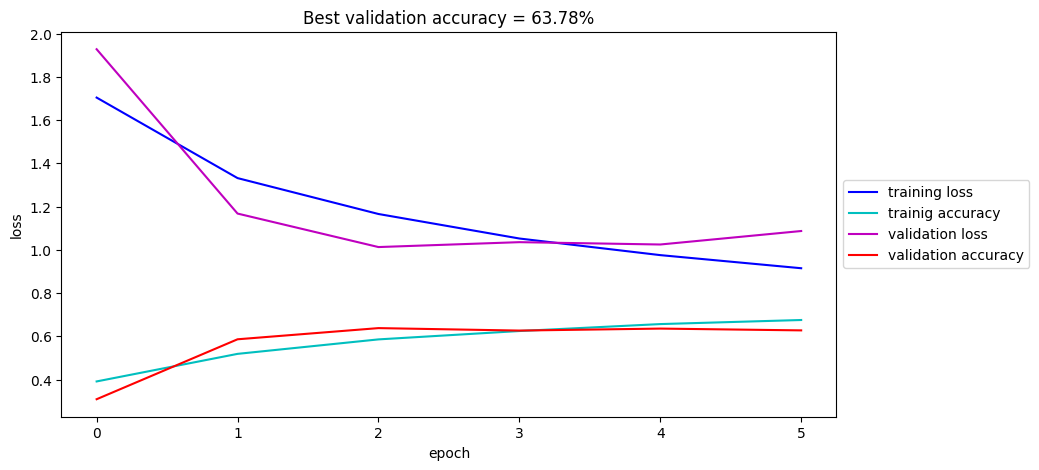

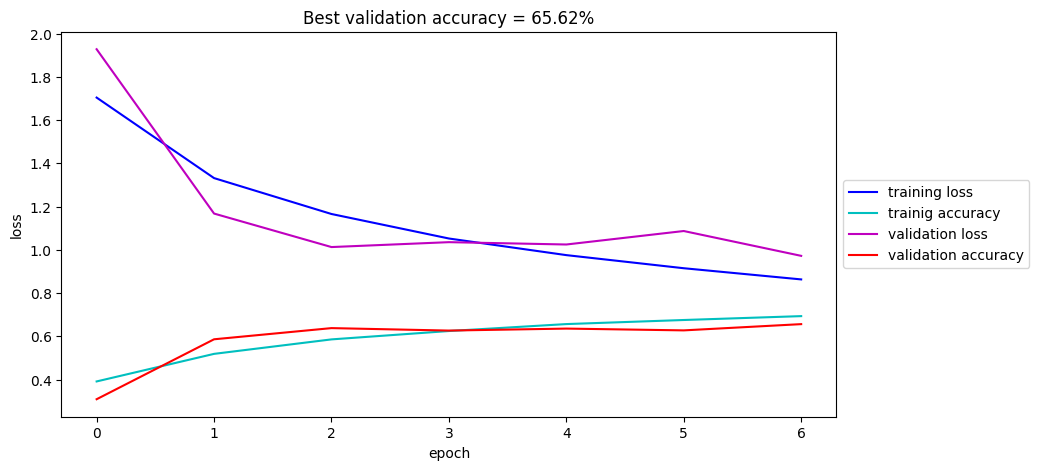

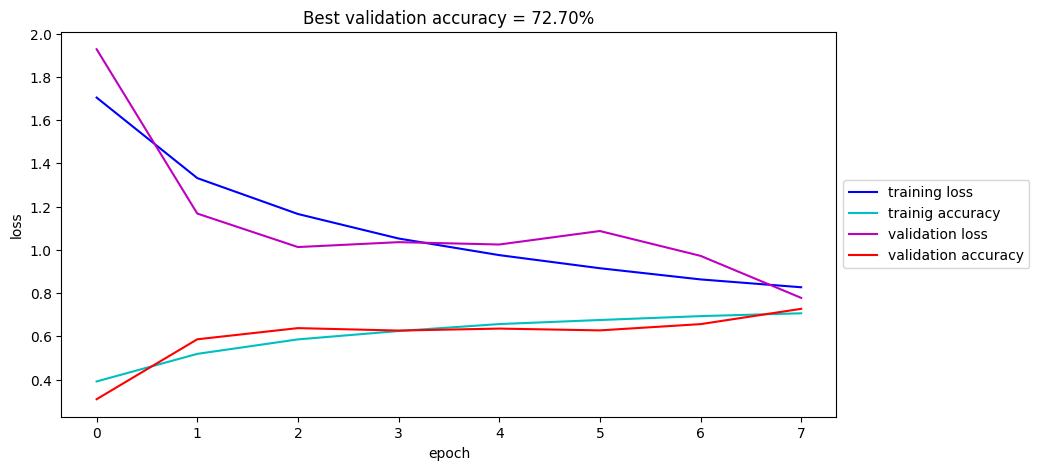

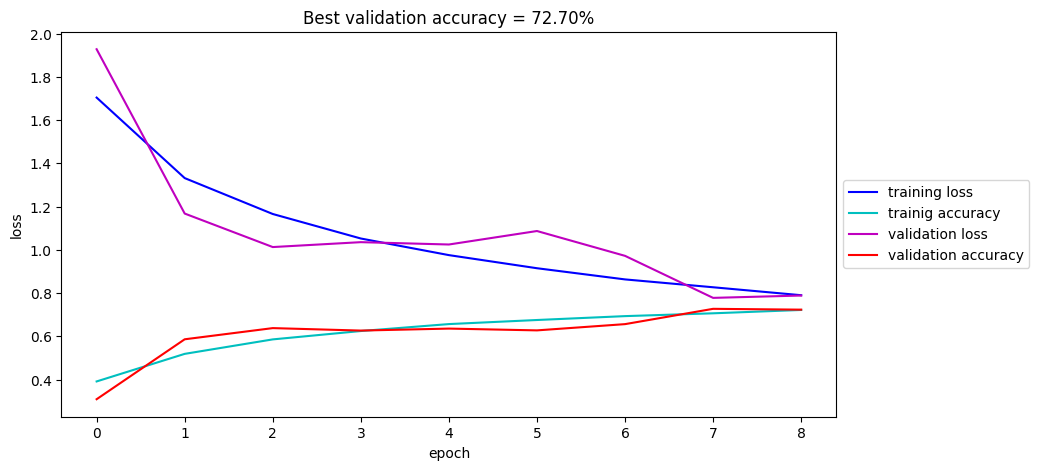

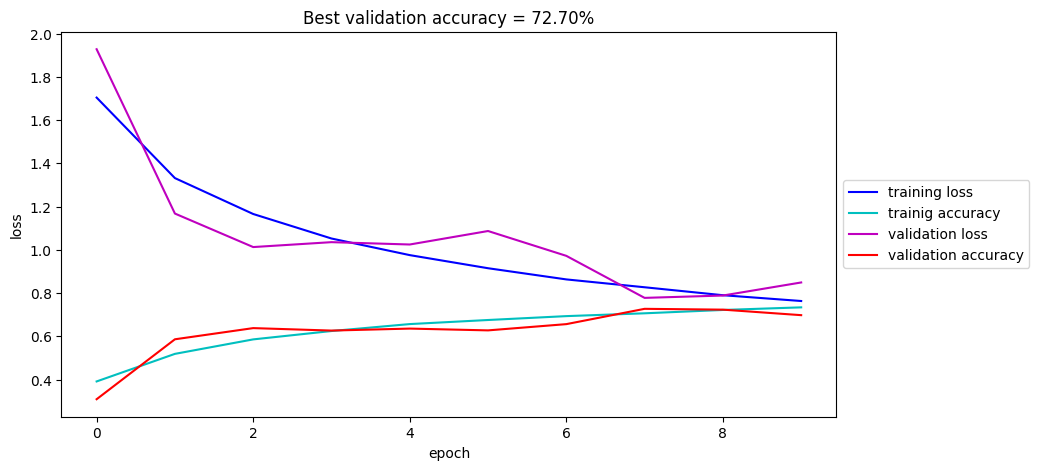

In [30]:
# train and validate network
network_filepath = os.path.join(file_dir, "best_model_net_nonlin.h5")
train_network(network, train_x, train_y_one_hot, val_x, val_y_one_hot, n_epoch, batch_size, network_filepath)

In [33]:
# reload the model for best accuracy
best_network = keras.models.load_model(network_filepath)

network_name = "name_task_6"
test_prediction = best_network.predict(test_x, batch_size=128)
test_y = np.argmax(test_prediction, axis=1)

# write to csv
ho = open(f"results_{network_name}", "w")
ho.write("filename, label\n")
for filename, label in zip(batches["cifar10-test"]["filenames"], test_y):
  ho.write(f"{filename}, {label}\n")
ho.close()

79/79 [==============================] - 28s 352ms/step
